# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## PROBLEM STATEMENT

- We will be exploring the Starbuck’s Dataset which simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. We want to make a recommendation engine that recommends Starbucks which offer should be sent to a particular customer.
- There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a required amount that the user is expected to spend. Offers can be delivered via multiple channels.
- We are interested to answer the following questions:
    1. Which offer should be sent to a particular customer to let the customer buy more?
    1. What is the impact of the customer demographic on the offer completion?
    1. What is the impact of the membership duration on the offer completion?
    1. Which are the best channels for that leads to the most offer completion?

STRATEGY
- First, I will wrangle and combine the data from offer portfolio, customer profile, and transaction. Each row of this combined dataset will describe the customer demographic data, offer's attributes, and whether the offer was successful. In this, I will take into account the possibility that a person may have completed the offer without even actually viewing the offer. Such outliers will have to be taken care and only those transaction will be considered where the user have actually viewed the offer and then completed the offer.
- Second, I will create a model (I am thinking Random Forest) that will be able to predict the offer success based on the provided customer demographics and the offer attributes.
- Third, I will obtain the important feature columns that influences the success of an offer and use the visualization of the data to answer the questions that were framed above.

## METRICS

I will assess the accuracy and F1-score of the model. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight to its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics". 

## DATA WRANGLING

### PORTFOLIO

In [3]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.shape

(10, 6)

#### DATA WRANGLING STEPS
1. Change column ordering
1. Change the name of the 'id' column to 'offerid'
1. Generate One-Hot encoded columns from 'offertype' column (and replace original)
1. Generate One-Hot encoded columns from 'channels' column [with multiple labels] (and replace original)

In [5]:
# Change column ordering
portfolio = portfolio[["id", "difficulty", "reward", "duration", "offer_type", "channels"]]

# Change the name of the 'id' column to 'offerid'
portfolio.rename(columns={"id": "offerid"}, inplace = True)

# One-Hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offer_type'])

# One-Hot encode the 'channels' columns
multi_onehot = MultiLabelBinarizer()
multi_onehot.fit(portfolio['channels'])
channels_df = pd.DataFrame(multi_onehot.transform(portfolio['channels']), columns=multi_onehot.classes_)

# Add the new columns to the root dataset
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

# Drop the "offertype" & "channels" column
portfolio = portfolio.drop(columns=['offer_type', 'channels'])

In [6]:
portfolio.head(10)

,offerid,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,2,7,0,1,0,1,1,0,1


In [7]:
portfolio.shape

(10, 11)

In [8]:
portfolio.describe()

,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,7.700000,4.200000,6.500000,0.400000,0.400000,0.200000,1.0,0.900000,0.600000,0.800000
std,5.831905,3.583915,2.321398,0.516398,0.516398,0.421637,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,5.000000,2.000000,5.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,8.500000,4.000000,7.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,10.000000,5.000000,7.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000
max,20.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


### PROFILE

In [9]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [10]:
profile.shape

(17000, 5)

#### DATA WRANGLING STEPS
1. Change column ordering
1. Change the name of the 'id' column to 'customerid'
1. Convert missing value encoded as 118 to N/A in the "age" column
1. Remove customers with N/A income data, N/A gender data and unspecified gender
1. Transform the 'became_member_on' column to a datetime object
1. Perform Encoding on the "gender" column

In [11]:
# Change column ordering
profile = profile[["id", "age", "gender", "income", "became_member_on"]]

# Change the name of the 'id' column to 'customerid'
profile.rename(columns={"id": "customerid"}, inplace = True)

# Convert missing value encoded as 118 to N/A in the "age" column
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

# drop all missing values
profile = profile[profile['gender'] != 'O'] # Remove customers with unspecified gender
profile.dropna(inplace=True)
profile = profile.reset_index(drop=True)

# the number of days since the user is a member of starbucks
profile['membership_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['membership_days'] = profile['membership_days'].dt.days
profile = profile.drop(columns=['became_member_on'])

# Perform Encoding on the "gender" column
profile["gender"] = profile["gender"].map({'M': 1, 'F': 0})

In [12]:
profile.head()

,customerid,age,gender,income,membership_days
0,0610b486422d4921ae7d2bf64640c50b,55.0,0,112000.0,803
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,0,100000.0,870
2,e2127556f4f64592b11af22de27a7932,68.0,1,70000.0,518
3,389bc3fa690240e798340f5a15918d5c,65.0,1,53000.0,594
4,2eeac8d8feae4a8cad5a6af0499a211d,58.0,1,51000.0,684


In [13]:
profile.shape

(14613, 5)

In [14]:
profile.describe()

,age,gender,income,membership_days
count,14613.000000,14613.000000,14613.000000,14613.000000
mean,54.393417,0.580579,65435.707931,949.991035
std,17.400201,0.493481,21633.524110,419.681797
min,18.000000,0.000000,30000.000000,427.000000
25%,42.000000,0.000000,49000.000000,635.000000
50%,55.000000,1.000000,64000.000000,785.000000
75%,66.000000,1.000000,80000.000000,1225.000000
max,101.000000,1.000000,120000.000000,2250.000000


### TRANSCRIPT

In [15]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [16]:
transcript.shape

(306534, 4)

In [17]:
# Exploration of the transcript records of one user
transcript[transcript['person']=='aa4862eba776480b8bb9c68455b8c2e1']

,event,person,time,value
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
20284,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,18,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
53183,offer received,aa4862eba776480b8bb9c68455b8c2e1,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
65845,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
83400,transaction,aa4862eba776480b8bb9c68455b8c2e1,210,{'amount': 12.33}
83401,offer completed,aa4862eba776480b8bb9c68455b8c2e1,210,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
110836,offer received,aa4862eba776480b8bb9c68455b8c2e1,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
123541,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
150604,offer received,aa4862eba776480b8bb9c68455b8c2e1,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
174355,transaction,aa4862eba776480b8bb9c68455b8c2e1,426,{'amount': 15.95}


#### DATA WRANGLING STEPS
1. Change the name of the 'person' column to 'customerid'
1. Remove customer id's that are not in the customer profile DataFrame
1. Extract the offerid from the value column into a separate column
1. Only keep the following events: offer viewed, offer completed
1. Change column ordering

In [18]:
# Change the name of the 'person' column to 'customerid'
transcript.rename(columns={"person": "customerid"}, inplace = True)

# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customerid'].isin(profile['customerid'])]

# Extract the offerid from the value column into a separate column
transcript['offerid'] = transcript['value'].apply(lambda elem: list(elem.values())[0])
transcript = transcript.drop(columns=['value'])

# Only keep the following events: offer viewed, offer completed
transcript = transcript[(transcript['event'] == "offer viewed") | (transcript['event'] == "offer completed")]

# Change column ordering
transcript = transcript[["customerid", "offerid", "event", "time"]]

transcript = transcript.reset_index(drop=True)

In [19]:
transcript.head(10)

,customerid,offerid,event,time
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
1,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed,0
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0
3,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,offer viewed,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer viewed,0
5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer completed,0
6,8c7df0c393db488aac3e58b06a7ea5f9,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0
7,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0
8,262ad0fb526a4d53b572007da60cce24,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
9,f8aedd0cbea0419c806842b4265b82e5,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0


Now what we want to do is to create a column named as response. For a particular customer, if a particular offer was viewed and then the offer was completed, the value in the response column for that particular offer should be one. If a particular offer was only viewed and not completed, then the value in the response column for that particular offer should be zero. This will signify the response of an individual towards different offfers. Note that the sequence of viewing the offer and then completing the offer should be maintained. 

In [20]:
transcript = transcript.groupby('customerid')

In [21]:
cleaned_transaction = []
for customer in tqdm(list(transcript.groups)): 
    customer_data = transcript.get_group(customer).drop_duplicates(subset=["offerid","event"])
    for value in customer_data["offerid"].value_counts().items():
        if(value[1] == 1):
            offer_complete_cond = customer_data["event"][list(customer_data.loc[customer_data['offerid']==value[0]].index)[0]] == "offer completed"
            if(offer_complete_cond == True):
                pass
            else:
                cleaned_transaction.append([customer, value[0], 0])
        else:
            event1 = customer_data["event"][list(customer_data.loc[customer_data['offerid']==value[0]].index)[0]]
            event2 = customer_data["event"][list(customer_data.loc[customer_data['offerid']==value[0]].index)[1]]
            if((event1 == 'offer viewed') & (event2 == 'offer completed')):
                cleaned_transaction.append([customer, value[0], 1])
            else:
                cleaned_transaction.append([customer, value[0], 0])

100%|██████████| 14534/14534 [01:23<00:00, 173.28it/s]


In [22]:
transcript = pd.DataFrame(cleaned_transaction, columns =['customerid', 'offerid', 'response'])
transcript.head(10)

,customerid,offerid,response
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
5,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0
7,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
8,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1
9,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1


In [23]:
transcript.shape

(41835, 3)

### COMBINED DATASET

Starbucks Dataset = Profile + Portfolio + Transcript

Note: Removing the customerid and the offerid column since we already gathered all the relevant information

In [24]:
starbucks_dataset = pd.merge(pd.merge(profile, transcript, on='customerid'), portfolio, on='offerid')
starbucks_dataset = starbucks_dataset.drop(columns=['customerid', 'offerid'])
# Change column ordering
starbucks_dataset = starbucks_dataset[['age', 'gender', 'income', 'membership_days',
                                       'difficulty', 'reward', 'duration', 'bogo', 'discount',
                                       'informational', 'email', 'mobile', 'social', 'web', 'response']] 
starbucks_dataset[["age", "income"]] = starbucks_dataset[["age", "income"]].astype(int)
starbucks_dataset.head()

,age,gender,income,membership_days,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web,response
0,75,0,100000,870,5,5,5,1,0,0,1,1,1,1,0
1,65,1,53000,594,5,5,5,1,0,0,1,1,1,1,1
2,61,0,57000,745,5,5,5,1,0,0,1,1,1,1,1
3,67,1,96000,1860,5,5,5,1,0,0,1,1,1,1,1
4,96,0,89000,678,5,5,5,1,0,0,1,1,1,1,1


In [25]:
starbucks_dataset.shape

(41835, 15)

## DATA VISUALIZATION

In [26]:
def distribution_viz(column):
    """ Plot a histogram for a particular column to visualize the distribution
        for the case when the response is zero (offer not completed) and
        for the case when the response is zero (offer was completed).

    Parameters:
    column (string): The column you want to plot the distribution of

    Returns:
    Will simply show two histograms related to the given column to compare the distribution for both the response


    """
    fig = plt.figure()
    ax0 = fig.add_subplot(1, 2, 1)
    ax0.set_xlabel("Response = 0")
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.set_xlabel("Response = 1")

    starbucks_dataset[starbucks_dataset["response"]==0][column].plot(kind="hist", figsize=(20, 6), ax = ax0)
    starbucks_dataset[starbucks_dataset["response"]==1][column].plot(kind="hist", color = "r", figsize=(20, 6), ax = ax1)

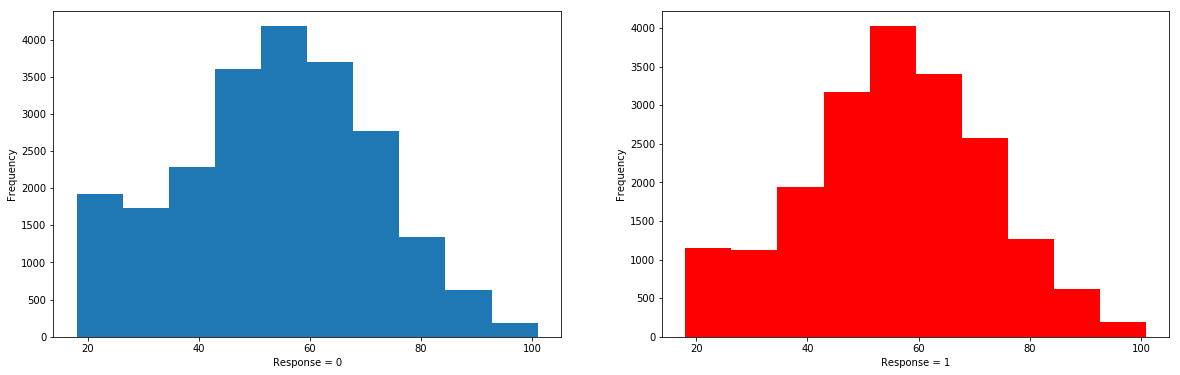

In [27]:
# Age Distribution
distribution_viz("age")

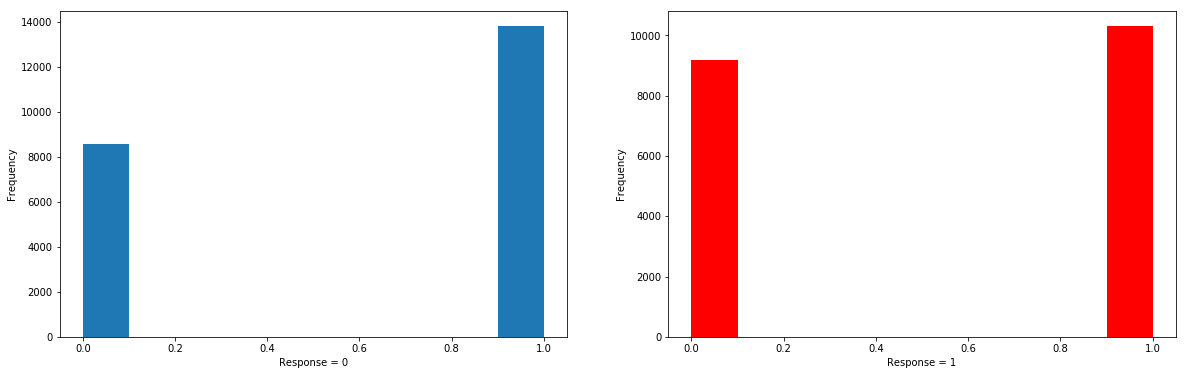

In [28]:
# Gender Distribution
distribution_viz("gender")

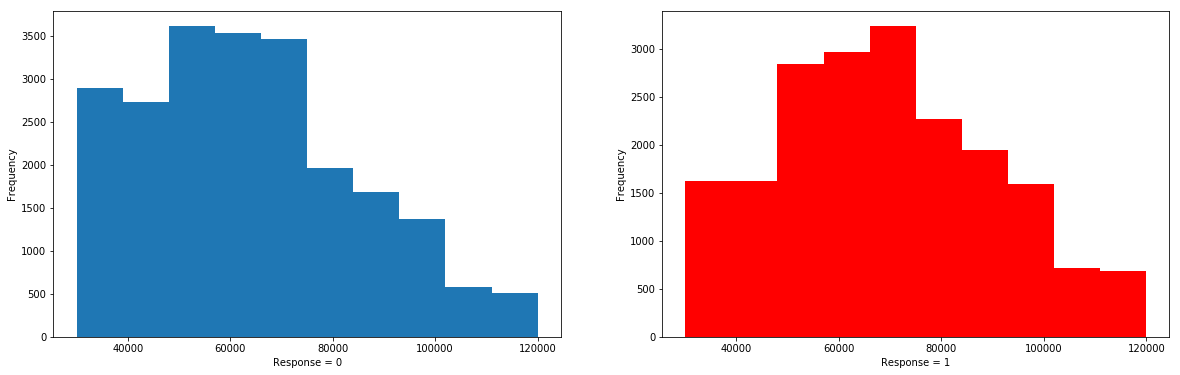

In [29]:
# Income Distribution
distribution_viz("income")

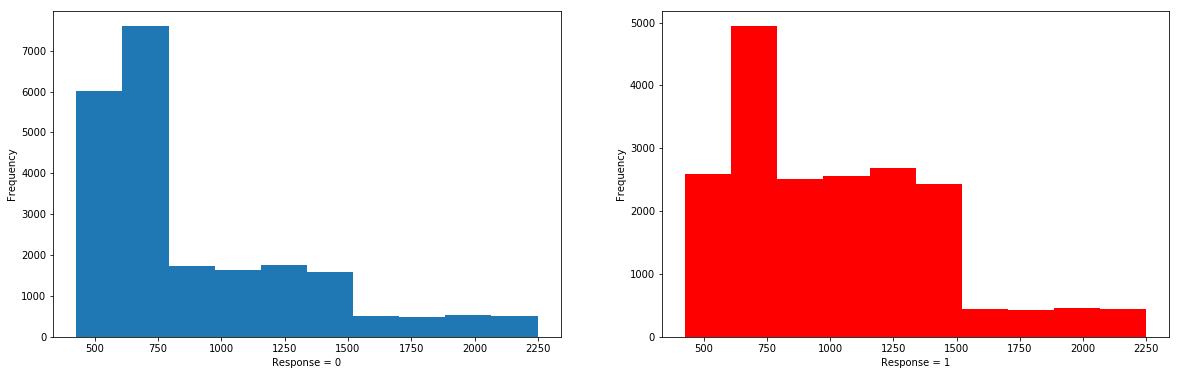

In [30]:
# Membership Days Distribution
distribution_viz("membership_days")

## IMPLEMENTATION: MACHINE LEARNING MODEL

The "informational" column will not be taken into account for the simple reason that the impact is not directly measurable.

In [31]:
starbucks_dataset_ml = starbucks_dataset[(starbucks_dataset["bogo"] == 1) | (starbucks_dataset["discount"] == 1)]

In [32]:
X = starbucks_dataset_ml[['age', 'gender', 'income', 'membership_days',
                            'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web']].values
y = starbucks_dataset_ml['response'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (27143, 11) (27143,)
Test set: (6786, 11) (6786,)


In [34]:
#Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

In [35]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.64367816092
F1 Score: 0.698729130326


## REFINEMENT

Now we will refine the model hyperparameters by using Random Grid Search technique

In [36]:
rf = RandomForestClassifier(random_state = 4)

# Number of trees in random forest
n_estimators = [150, 200, 250, 300]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_randomsearch = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 30,
                               cv = 3,
                               verbose = 2,
                               random_state = 4,
                               n_jobs = 3)

rf_randomsearch.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2 .......
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2 .......
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2 .......
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, total=  23.1s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2 ......
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, total=  23.2s
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, total=  23.1s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2 ......
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2 ......
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, total=  17.4s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2 .......
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, total=  17.3s
[CV] n_estimators=200, min_samples_split=5, m

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.8min


[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, total=  22.5s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=4 .......
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, total=  17.1s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2 .......
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, total=  17.0s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2 .......
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=4, total=  17.1s
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=2 .......
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, total=  19.0s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4 ......
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, total=  18.9s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4 ......
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, total=  18.9s
[CV] n_estimators=300

[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  9.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=4, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=3,
          param_distributions={'n_estimators': [150, 200, 250, 300], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=4, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

### BEST PARAMETERS

In [37]:
rf_randomsearch.best_params_

{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4}

### BEST ESTIMATOR

In [38]:
rf_randomsearch.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=4, verbose=0, warm_start=False)

In [39]:
rf = RandomForestClassifier(n_estimators = 300, min_samples_split = 10, min_samples_leaf = 4, random_state = 4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.665487768936
F1 Score: 0.720305569246


## RESULTS AND ANALYSIS

In [41]:
feature_imp = pd.Series(rf.feature_importances_,index=['age', 'gender', 'income', 'membership_days',
                       'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web']).sort_values(ascending=False)
feature_imp

membership_days    0.423288
income             0.240765
age                0.213765
reward             0.046725
gender             0.027614
duration           0.019099
difficulty         0.011349
social             0.008973
web                0.007130
mobile             0.001292
email              0.000000
dtype: float64

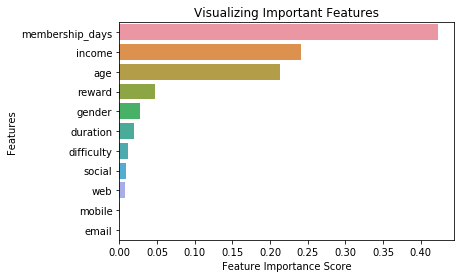

In [42]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### VALIDATE MODEL'S SOLUTION
We will be validating the robustness of the model’s solution by running the model with multiple different random states and then checking the mean / variance of the results

In [44]:
import statistics
random_states = [4, 11, 1656, 65278, 7656451]
accuracy_score = []
f1_score = []
for random_state in random_states:
    rf = RandomForestClassifier(n_estimators = 150, min_samples_split = 10, min_samples_leaf = 4, random_state = random_state)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    accuracy_score.append(metrics.accuracy_score(y_test, y_pred))
    f1_score.append(metrics.f1_score(y_test, y_pred))
    
print("Mean Model Accuracy:",statistics.mean(accuracy_score))
print("Variance of Model Accuracy:",statistics.variance(accuracy_score))
print("Mean Model F1 Score:",statistics.mean(f1_score))
print("Variance of Model F1 Score:",statistics.variance(accuracy_score))

Mean Model Accuracy: 0.664161508989
Variance of Model Accuracy: 1.75896544688e-06
Mean Model F1 Score: 0.719837831379
Variance of Model F1 Score: 1.75896544688e-06


By observing the above values, we can confirm that the model that was developed is very robust to data changes!

Now the best tuned model has been created which gave us the important features. We have also performed data visualization about the important columns. Armed with this information, we will be able to answer the questions we had proposed initially.
1.	Which offer should be sent to a particular customer to let the customer buy more?

We were able to achieve an accuracy value of 66.54% which shows that our model will be able to predict the offer response based on the customer demographics and the offer details very nicely. We also were able to get a high value of F1 Score (72.03%) which signifies that the model is not biased towards one particular result. By observation of the important features result, we can say that offers having a higher reward have higher offer completion rate. Simply put, the more the reward, the better the chance of an individual responding to the offers. The duration of the offer also plays an important role and thus offers having a longer duration tends to have a getter completion rate. The understanding that the people will have more time to complete the offer as compared to offers whose duration is very less. Imagine you getting the offer on a Monday, but the offer expires in 5 days. Let’s say you may have a habit of going to Starbucks on weekends. But since the offer will expire in 5 days (on Friday), you will not be able to take benefit from the same. Now if the offer duration was more, let’s say 7 days then you will be able to take the benefit of the offer on weekends more easily.
2.	What is the impact of the customer demographic on the offer completion?

It can be observed from the important features graph (Feature Importance: refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric) that the following parameters have the most influence on the offer completion rate related to the customer demographics:
•	Gender
Reasoning: In the group of people who responds positively to the offers, the contribution of female members is more as compared to the group of people who do not respond to the offers.
•	Income
Reasoning: People who have comparatively high income are more likely to respond to the offers.
•	Age
Reasoning: Age plays an important factor in deciding as to how likely a person will respond to the offers.
3.	What is the impact of the membership duration on the offer completion?

People who are Starbucks member for very long are more loyal and more likely to respond to the offers.
4.	Which are the best channels for that leads to the most offer completion?

The column mobile and email have a negligible contribution for the simple reason that the above two options are present for all kind of promotions (offers) and thereby are not providing any additional information. We can also see that social media have a greater influence and impact on the offer completion as compared to other channels!


## FUTURE IMPROVEMENTS

- It is possible to build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Test additional machine learning models.
- Make a web app